In [86]:
%pip install nltk pandas transformers
%pip install SpeechRecognition pydub
%pip insall wordcloud
%pip install matplotlib
%pip install -U jupyter ipywidgets tqdm
%pip install --upgrade setuptools
%pip install tf-keras
%pip install torch torchvision torchaudio
%pip install tensorflow
%pip install tensorflow --upgrade
%pip install coqui-stt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "insall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries
import speech_recognition as sr
import nltk
import os
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from pydub import AudioSegment
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import HTML, display

In [3]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/hoobot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoobot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Speech to Text

In [4]:
# Convert MP3 to WAV for easier processing by SpeechRecognition
def convert_audio(input_file):
    sound = AudioSegment.from_mp3(input_file)
    output_file = "converted_file.wav"
    sound.export(output_file, format="wav")
    return output_file

In [5]:
 # Transcribe audio to text
def transcribe_audio(file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
            return text
        except sr.UnknownValueError:
            return "Google Speech Recognition could not understand audio"
        except sr.RequestError as e:
            return "Could not request results from Google Speech Recognition service; {0}".format(e)



In [6]:
# Split video to 30 second chunks for faster processing and less chance of error
def convert_and_chunk_audio(input_file, output_folder="audio_chunks", chunk_length_ms=30000):
    # Create the output folder if it doesn't already exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    sound = AudioSegment.from_mp3(input_file)
    chunks = []

    for i in range(0, len(sound), chunk_length_ms):
        chunk = sound[i:i+chunk_length_ms]
        chunk_name = f"chunk{i//chunk_length_ms}.wav"
        chunk_path = os.path.join(output_folder, chunk_name)  # Save chunks to the specified folder
        chunk.export(chunk_path, format="wav", parameters=["-ar", "16000"])
        chunks.append(chunk_path)

    return chunks

In [7]:
def parallel_transcribe_audio(chunks):
    transcriptions = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_chunk = {executor.submit(transcribe_audio, chunk): chunk for chunk in chunks}
        for future in as_completed(future_to_chunk):
            chunk = future_to_chunk[future]
            try:
                transcription = future.result()
                transcriptions.append(transcription)
            except Exception as exc:
                print(f'Chunk {chunk} generated an exception: {exc}')
    return " ".join(transcriptions)

In [8]:
def process_audio_file(input_file):
    chunks = convert_and_chunk_audio(input_file)
    full_transcription = parallel_transcribe_audio(chunks)
    print("Full Transcription:", full_transcription)

    with open("transcribed_text.txt", "w") as text_file:
        text_file.write(full_transcription)

## Transcription Driver Code

In [9]:
# Replace 'Interview_Audio.mp3' with the exact audio file
# process_audio_file("Exit Interview Questions from We.mp3")
process_audio_file("Why I left my job at Google (as a software engineer).mp3")

Full Transcription: and you know it was it was great not before I got into Google I would be one of those people who would just go like Costco and just get as many samples as I could and that would be my lunch I would love food samples and I might go Trader Joe's and grab their free coffee and I might go to chocolate shops and just get free samples everywhere and you know I was just hungry and starving basically everywhere I went and after Google that kind of changed me a little bit basically I was able to get as many free samples as I wanted that Google because hi and welcome back to another episode of the tech lead my name is the tech lead and I will be the tech lead today I wanted to talk about why I left my six-figure job at Google because for a lot of people they imagine that once they get into Google it will be happily ever after from there on out like it's a great company to work for it's kind of the lifelong dream for a lot of people and once they get in they imagine they'll ju

## Sentiment Analysis

In [17]:
def analyze_sentiment(text):
    # Load the tokenizer and sentiment-analysis pipeline
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    # Models for sentiment analysis
    # Default model
    # classifier = pipeline('sentiment-analysis', model="bert-base-uncased")
    # Model based from product reviews
    # classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")
    # Model based on Twitter data
    classifier = pipeline('sentiment-analysis', model="CardiffNLP/twitter-roberta-base-sentiment")
    # classifier = pipeline('sentiment-analysis', model="bert-base-uncased-finetuned-sst-2-english")


    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    sentiment_results = []
    for sentence in sentences:
        # Check if the length of the tokens does not exceed the maximum size
        tokens = tokenizer.tokenize(sentence)
        if len(tokens) > 510:
            tokens = tokens[:510]  # truncate tokens if they are too long
        # Convert tokens back to string
        sentence_text = tokenizer.convert_tokens_to_string(tokens)
        # Analyze sentiment of the sentence
        result = classifier(sentence_text)
        # Pair each sentence with its result
        sentiment_results.append((sentence, result[0]))  

    return sentiment_results

In [20]:
# Sentiment Analysis Visualization
def print_sentiment_results(results):
    # Mapping the labels its meaning
    label_map = {
        'LABEL_2': ('Positive', 1),
        'LABEL_1': ('Neutral', 2),
        'LABEL_0': ('Negative', 3)
    }
    
    # Colors for each sentiment
    color_map = {
        'Positive': 'green',
        'Neutral': 'gray',
        'Negative': 'red'
    }

    # Sort results by custom order defined in label_map and then by score within each label
    results = sorted(results, key=lambda x: (label_map[x[1]['label']][1], -x[1]['score']))

    # HTML string to accumulate the result
    html_output = "<div>"
    
    for sentence, result in results:
        label_description = label_map[result['label']][0]
        color = color_map[label_description]
        score = result['score']
        html_output += f"<p><strong>Sentence:</strong> {sentence}<br>"
        html_output += f"<strong>Sentiment:</strong> <span style='color: {color};'>{label_description}</span>, "
        html_output += f"<strong>Score:</strong> {score:.2f}</p>"
    
    html_output += "</div>"
    display(HTML(html_output))


## Name Entity Recognition

In [80]:
def extract_entities(text, keywords=None):
    # Load the tokenizer and model for named entity recognition
    tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
    model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
    ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    
    # Collecting relevant entities
    relevant_entities = []
    for sentence in sentences:
        entities = ner(sentence)
        found_entities = {entity['word'].lower() for entity in entities}

        # Adding keyword matching
        for word in sentence.split():
            if word.lower() in keywords:
                found_entities.add(word.lower())

        if found_entities:
            relevant_entities.append((sentence, found_entities))

    return relevant_entities


## Word Cloud 

In [119]:
def generate_word_cloud(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    
    # Load stop words
    stop_words = set(stopwords.words('english'))
    
    # Additional common but irrelevant words could be filtered out
    additional_stopwords = {'may', 'also', 'many', 'must', 'can', 'much', 'every', 'would', 'could', 'today', 'felt', 'us'}
    stop_words.update(additional_stopwords)

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stop_words and word.isalnum()]
    
    # Frequency distribution of words
    freq_dist = nltk.FreqDist(filtered_words)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freq_dist)
    
    # Display the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Output Driver Code

In [7]:
# Analyze on sample text for better accuracy
# sample_text_file = "sample.txt"
sample_text_file = "sample2.txt"
with open(sample_text_file, "r") as file:
    sample_text = file.read()

#### Sentiment Output

In [21]:

sentiment_results = analyze_sentiment(sample_text)
print_sentiment_results(sentiment_results)

In [115]:
# Sort results by score descending and get the top 10
sentiment_results = analyze_sentiment(sample_text)
top_results = sorted(sentiment_results, key=lambda x: x[1]['score'], reverse=True)[:100]

# Print each sentence with its corresponding sentiment result
for sentence, result in top_results:
    print(f"Sentence: {sentence}\nSentiment: {result['label']}, Score: {result['score']}\n")

# Print raw sentiment results
# for sentence, result in sentiment_results:
#     print(f"Sentence: {sentence}\nSentiment: {result['label']}, Score: {result['score']}\n")


Sentence: We wish you the best in your future endeavors and hope you achieve great success in your new role.
Sentiment: LABEL_2, Score: 0.9832708239555359

Sentence: Thanks again for the opportunity to work here, I've gained a lot of valuable experience and I hope we can keep in touch.
Sentiment: LABEL_2, Score: 0.982029139995575

Sentence: This environment made it enjoyable to come to work every day.
Sentiment: LABEL_2, Score: 0.965398371219635

Sentence: That's wonderful to hear.
Sentiment: LABEL_2, Score: 0.9600357413291931

Sentence: Good afternoon and thank you for joining this exit interview.
Sentiment: LABEL_2, Score: 0.9579610228538513

Sentence: Investing more in employee well-being can really enhance productivity and job satisfaction.
Sentiment: LABEL_2, Score: 0.9473720192909241

Sentence: Thank you for those insights.
Sentiment: LABEL_2, Score: 0.9260537624359131

Sentence: Generally, the support was good, but there were occasions where I felt more direct communication rega

#### Name Entity Recognition Output

In [97]:
# Keyword listing
keywords = ["employee", "HR", "vacancies", "retention", "management"]

# Name Entity Recognition Driver
relevant_entities = extract_entities(sample_text, keywords=keywords)

# Print extracted entities and their sentences
for sentence, entities in relevant_entities:
    print(f"Sentence: {sentence}\nEntities: {', '.join(entities)}\n")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence: It was great how everyone was eager to help each other and how management was accessible.
Entities: management

Sentence: How did you perceive the management and their approach?
Entities: management

Sentence: The management style was generally supportive, but I would have benefited from more regular feedback on my performance rather than waiting for annual review periods.
Entities: management

Sentence: There were times when the workload was intense, and it might help with employee retention if there was more emphasis on maintaining balance.
Entities: employee, retention



#### Word Cloud

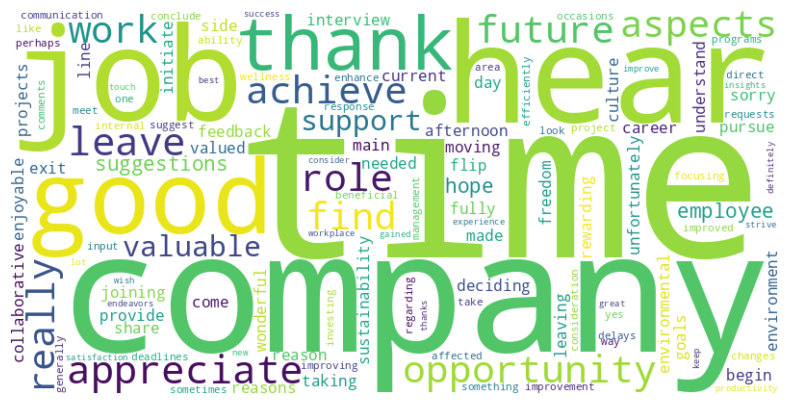

In [120]:
generate_word_cloud(sample_text)